In [17]:
import torch
import evaluate
import pandas as pd
import numpy as np
import re
import os
import gc
import traceback
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, Dataset, Audio
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    GenerationConfig,
    Seq2SeqTrainingArguments, # Used indirectly for device placement helper
    Seq2SeqTrainer # Used indirectly for device placement helper
)
from peft import PeftModel, PeftConfig
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Use standard tqdm if not in notebook


In [18]:
# --- Configuration ---
MODEL_ID = "openai/whisper-large-v3"
# !! MODIFY THIS PATH !!
ADAPTER_CHECKPOINT_PATH = "./whisper-large-v3-is-raddromur-lora-wandb/checkpoint-180" # Example path, use your checkpoint
# !! ------------- !!

# Evaluation Dataset Configuration (Samrómur Milljón)
EVAL_DATASET_ID = "language-and-voice-lab/samromur_milljon"
# Choose one of the demographic splits, e.g., 'female_18to49_yrs', 'male_18to49_yrs', 'female_lt_18_yrs', etc.
EVAL_SPLIT = "female_18to49_yrs" # Example split
EVAL_SUBSET_SIZE = 1000 # Number of samples to randomly select for evaluation (adjust as needed)

TARGET_LANGUAGE = "is"
TASK = "transcribe"
MODEL_PRECISION = torch.bfloat16 # Use the same precision as training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EVAL_BATCH_SIZE = 1 # Adjust based on GPU memory during evaluation

print(f"Using device: {DEVICE}")
print(f"Using model precision: {MODEL_PRECISION}")
print(f"Evaluating on: {EVAL_DATASET_ID} (Split: {EVAL_SPLIT}, Subset Size: {EVAL_SUBSET_SIZE})")

# --- Load Metrics ---
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")


Using device: cuda
Using model precision: torch.bfloat16
Evaluating on: language-and-voice-lab/samromur_milljon (Split: female_18to49_yrs, Subset Size: 1000)


In [19]:
# --- Text Normalization Function ---
# Samromur 'normalized_text' is already lowercase, no punctuation/digits.
# This function primarily handles potential extra whitespace.
chars_to_remove_regex = r'[<\[\].,?!\-:;"]' # Keep for Whisper output normalization

def normalize_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(chars_to_remove_regex, '', text).strip()
    return text

# --- Load Processor ---
print(f"\nLoading processor for {MODEL_ID}...")
try:
    processor = WhisperProcessor.from_pretrained(MODEL_ID, language=TARGET_LANGUAGE, task=TASK)
    print("Processor loaded.")
except Exception as e:
    print(f"Error loading processor: {e}")
    exit()



Loading processor for openai/whisper-large-v3...
Processor loaded.


In [20]:
# --- Load Evaluation Dataset ---
print(f"\nLoading evaluation dataset {EVAL_DATASET_ID} split '{EVAL_SPLIT}'...")
try:
    # Load the specific demographic split
    eval_dataset_full_split = load_dataset(EVAL_DATASET_ID, split=EVAL_SPLIT)
    print(f"Full split '{EVAL_SPLIT}' loaded with {len(eval_dataset_full_split)} samples.")

    # --- Select a Random Subset ---
    if EVAL_SUBSET_SIZE > len(eval_dataset_full_split):
        print(f"Warning: Requested subset size {EVAL_SUBSET_SIZE} is larger than the split size {len(eval_dataset_full_split)}. Using full split.")
        eval_dataset = eval_dataset_full_split
    else:
        print(f"Selecting random subset of {EVAL_SUBSET_SIZE} samples...")
        eval_dataset = eval_dataset_full_split.shuffle(seed=42).select(range(EVAL_SUBSET_SIZE))
        print(f"Subset selected.")

    # --- Preprocess Evaluation Dataset ---
    print("Preprocessing evaluation subset...")
    # Keep relevant columns: 'audio', 'normalized_text'
    reference_col = "normalized_text"
    eval_dataset = eval_dataset.remove_columns(
        [col for col in eval_dataset.column_names if col not in ["audio", reference_col]]
    )

    # Audio is already 16kHz, casting is good practice but optional
    eval_dataset = eval_dataset.cast_column("audio", Audio(sampling_rate=16000))

    # Rename reference column
    eval_dataset = eval_dataset.rename_column(reference_col, "reference")

    print("Dataset subset preprocessed.")
    print("Example reference:", eval_dataset[0]['reference'])

except Exception as e:
    print(f"Error loading or preprocessing dataset: {e}")
    exit()



Loading evaluation dataset language-and-voice-lab/samromur_milljon split 'female_18to49_yrs'...
Full split 'female_18to49_yrs' loaded with 331839 samples.
Selecting random subset of 1000 samples...
Subset selected.
Preprocessing evaluation subset...
Dataset subset preprocessed.
Example reference: sólargeisli kviknaði framundan


In [21]:
def evaluate_model(model, processor, dataset, device, batch_size=8):
    """Evaluates a Whisper model on a dataset and returns WER and CER."""
    model.eval()
    model.to(device)

    # --- START: Corrected GenerationConfig Handling ---
    # Use the generation_config attached to the model directly
    generation_config = model.generation_config

    # Override specific settings needed for evaluation
    generation_config.language = TARGET_LANGUAGE
    generation_config.task = TASK
    generation_config.forced_decoder_ids = None # Ensure processor handles start tokens
    generation_config.suppress_tokens = []    # Ensure no tokens are suppressed unless intended
    # --- END: Corrected GenerationConfig Handling ---


    all_predictions = []
    all_references = []
    stereo_count = 0

    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

    print(f"Starting evaluation loop with batch size {batch_size}...")
    try:
        for i, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            # --- NumPy Conversion & Mono Check ---
            # (Keep the conversion logic from the previous step)
            audio_arrays_raw = batch["audio"]["array"]
            processed_audio_np = []
            for array_or_tensor in audio_arrays_raw:
                if isinstance(array_or_tensor, torch.Tensor):
                    array = array_or_tensor.numpy()
                elif isinstance(array_or_tensor, np.ndarray):
                    array = array_or_tensor
                else: continue
                if array.ndim > 1 and array.shape[0] > 1 :
                    stereo_count += 1
                    array = np.mean(array, axis=0)
                processed_audio_np.append(array)
            if not processed_audio_np: continue
            # --- End Conversion ---

            # --- START: Modify Processor Call & Mask Handling ---
            # Prepare batch using the list of NumPy arrays
            # The processor output is a BatchFeature object (dict-like)
            processed_batch = processor(
                processed_audio_np,
                sampling_rate=batch["audio"]["sampling_rate"][0].item(),
                return_tensors="pt"
            )

            # Extract features and mask, move to device
            input_features = processed_batch.input_features.to(device, dtype=MODEL_PRECISION)            
            reference_texts = batch["reference"]

            # Generate predictions
            with torch.inference_mode():
                 with torch.autocast(device_type=device.type, dtype=MODEL_PRECISION):
                    # Pass the modified generation_config explicitly
                    predicted_ids = model.generate(input_features, generation_config=generation_config)

            # Decode and normalize
            predictions_decoded = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            predictions_norm = [normalize_text(pred) for pred in predictions_decoded]
            references_norm = [normalize_text(ref) for ref in reference_texts]

            all_predictions.extend(predictions_norm)
            all_references.extend(references_norm)

    except Exception as e:
         print(f"\n*** Error occurred during evaluation loop at batch {i}: {e} ***")
         print("--- Full Traceback ---")
         traceback.print_exc()
         print("----------------------")
         print("Evaluation stopped prematurely due to error.")
         # Compute partial metrics only if lists are not empty
         partial_wer = -1
         partial_cer = -1
         if all_references and all_predictions: # Check if lists have content
             partial_wer = wer_metric.compute(predictions=all_predictions, references=all_references) * 100
             partial_cer = cer_metric.compute(predictions=all_predictions, references=all_references) * 100
             print(f"Partial WER: {partial_wer:.2f}%, Partial CER: {partial_cer:.2f}% (on {len(all_predictions)} samples)")
         return {"wer": partial_wer, "cer": partial_cer, "stereo_files_found": stereo_count, "error": True}


    # --- Report Stereo Count ---
    print(f"\nProcessed {len(all_references)} samples. Found {stereo_count} potential stereo file(s) (converted to mono).")

    # Compute metrics if loop completes
    print("Computing WER and CER...")
    wer = wer_metric.compute(predictions=all_predictions, references=all_references)
    cer = cer_metric.compute(predictions=all_predictions, references=all_references)

    results_dict = {
        "wer": wer * 100,
        "cer": cer * 100,
        "stereo_files_found": stereo_count,
        "error": False
    }
    print("Evaluation loop finished successfully.")
    return results_dict

results = {}


In [22]:
# --- Evaluate Base Model ---
print(f"\n--- Evaluating Base Model ({MODEL_ID}) ---")
model_key = "Base Model"
# Default values in case of early failure (e.g., model loading)
results[model_key] = {
    "wer": float('inf'),
    "cer": float('inf'),
    "stereo_files_found": -1,
    "eval_error": True # Assume error until proven otherwise
}

try:
    # --- Model Loading ---
    print("Loading base model...")
    base_model = WhisperForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=MODEL_PRECISION,
        low_cpu_mem_usage=True,
        attn_implementation="sdpa" # Use consistent attention
    )
    base_model.to(DEVICE)
    print("Base model loaded.")

    # --- Run Evaluation ---
    # This call now returns the detailed dictionary
    eval_metrics = evaluate_model(base_model, processor, eval_dataset, DEVICE, EVAL_BATCH_SIZE)

    # --- Store Results ---
    # Update the results dictionary with values from eval_metrics
    # Use .get() with defaults in case eval_metrics is incomplete due to early error
    results[model_key]['wer'] = eval_metrics.get("wer", float('inf'))
    results[model_key]['cer'] = eval_metrics.get("cer", float('inf'))
    results[model_key]['stereo_files_found'] = eval_metrics.get("stereo_files_found", -1)
    results[model_key]['eval_error'] = eval_metrics.get("error", True) # Update error status

    # Print key results
    print(f"{model_key} Results: WER={results[model_key]['wer']:.2f}%, CER={results[model_key]['cer']:.2f}%")
    if results[model_key]['eval_error']:
        print(f"  Warning: Evaluation for {model_key} may not have completed fully (error flag set).")
    print(f"  Stereo files found/converted: {results[model_key]['stereo_files_found']}")


except Exception as e:
    # Catch errors during loading or other setup BEFORE evaluate_model is called
    print(f"--- Error during {model_key} loading or setup: {e} ---")
    # Log traceback for unexpected errors
    import traceback
    traceback.print_exc()
    # results[model_key] is already set to error defaults
    print(f"{model_key} Results: Evaluation could not be run due to setup error.")

finally:
    # --- Model Unloading ---
    print(f"\nUnloading {model_key}...")
    if 'base_model' in locals(): del base_model
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleared.")
    print("Model unloaded.")


--- Evaluating Base Model (openai/whisper-large-v3) ---
Loading base model...
Base model loaded.
Starting evaluation loop with batch size 1...


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Processed 1000 samples. Found 0 potential stereo file(s) (converted to mono).
Computing WER and CER...
Evaluation loop finished successfully.
Base Model Results: WER=34.15%, CER=11.05%
  Stereo files found/converted: 0

Unloading Base Model...
GPU memory cleared.
Model unloaded.


In [23]:
# --- Evaluate Adapter Model ---
print(f"\n--- Evaluating Adapter Model ({ADAPTER_CHECKPOINT_PATH}) ---")
model_key = "Fine-tuned Adapter"
results[model_key] = { # Default error values
    "wer": float('inf'), "cer": float('inf'), "stereo_files_found": -1, "eval_error": True
}
try:
    print("Loading base model for adapter...")
    base_model_for_adapter = WhisperForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=MODEL_PRECISION,
        low_cpu_mem_usage=True,
        attn_implementation="sdpa"
    )

    print("Loading LoRA adapter...")
    peft_model = PeftModel.from_pretrained(base_model_for_adapter, ADAPTER_CHECKPOINT_PATH)
    print("Adapter loaded.")
    peft_model.to(DEVICE)

    results["Fine-tuned Adapter"] = evaluate_model(peft_model, processor, eval_dataset, DEVICE, EVAL_BATCH_SIZE)
    print("Adapter Model Results:", results["Fine-tuned Adapter"])

except Exception as e:
    print(f"Error during adapter model evaluation: {e}")
    results["Fine-tuned Adapter"] = {"wer": float('inf'), "cer": float('inf')}
finally:
    print("\nUnloading adapter model...")
    if 'peft_model' in locals(): del peft_model
    if 'base_model_for_adapter' in locals(): del base_model_for_adapter
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleared.")


--- Evaluating Adapter Model (./whisper-large-v3-is-raddromur-lora-wandb/checkpoint-180) ---
Loading base model for adapter...
Loading LoRA adapter...
Adapter loaded.
Starting evaluation loop with batch size 1...


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


Processed 1000 samples. Found 0 potential stereo file(s) (converted to mono).
Computing WER and CER...
Evaluation loop finished successfully.
Adapter Model Results: {'wer': 33.071612291864085, 'cer': 10.58851391355832, 'stereo_files_found': 0, 'error': False}

Unloading adapter model...
GPU memory cleared.



--- Final Evaluation Results ---
                Model        wer        cer stereo_files_found eval_error  \
0          Base Model  34.154596  11.047957                  0      False   
1  Fine-tuned Adapter  33.071612  10.588514                  0        NaN   

   error  
0    NaN  
1  False  

Generating comparison graph...
Graph saved as whisper_samromur_evaluation_comparison.png

Evaluation script finished.


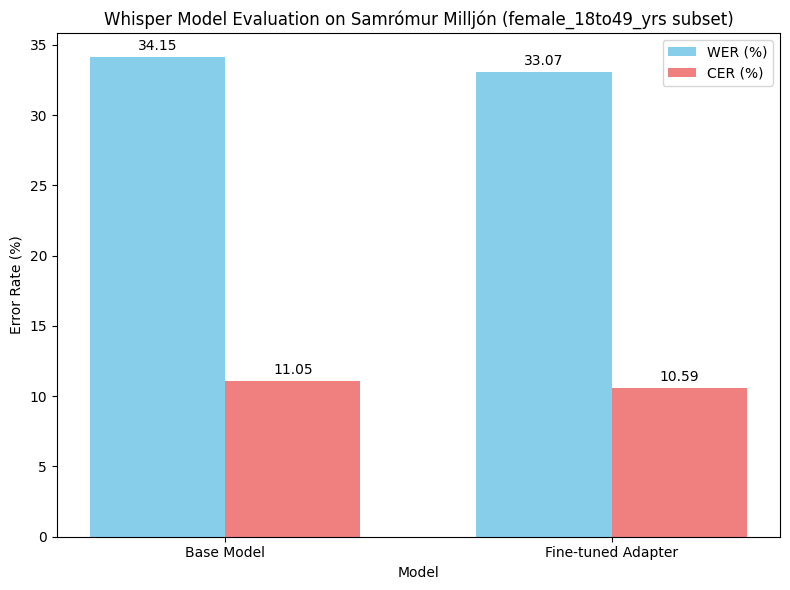

In [24]:
# --- Present Results ---
print("\n--- Final Evaluation Results ---")

results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={"index": "Model"})

print(results_df)

# --- Plotting ---
print("\nGenerating comparison graph...")
try:
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(results_df))

    bar1 = ax.bar(index - bar_width/2, results_df['wer'], bar_width, label='WER (%)', color='skyblue')
    bar2 = ax.bar(index + bar_width/2, results_df['cer'], bar_width, label='CER (%)', color='lightcoral')

    ax.set_xlabel('Model')
    ax.set_ylabel('Error Rate (%)')
    ax.set_title(f'Whisper Model Evaluation on Samrómur Milljón ({EVAL_SPLIT} subset)') # Updated title
    ax.set_xticks(index)
    ax.set_xticklabels(results_df['Model'])
    ax.legend()

    ax.bar_label(bar1, padding=3, fmt='%.2f')
    ax.bar_label(bar2, padding=3, fmt='%.2f')

    fig.tight_layout()
    plt.savefig("whisper_samromur_evaluation_comparison.png") # New filename
    print("Graph saved as whisper_samromur_evaluation_comparison.png")
    # plt.show()

except Exception as e:
    print(f"Error generating plot: {e}")

print("\nEvaluation script finished.")